# DL2DWH Lab

In this lab you are asked to cover the following points:
1. Data ingestion
2. Data understanding
3. Design and build a relational DWH
4. Query the DWH with Tableau (Desktop)
5. (Bonus) Plot the provenance graph

In [ ]:
!pip install awswrangler
!pip install pandas
!pip install sklearn
!pip install prov
!pip install seaborn
!pip install pydot
!pip install graphviz
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [ ]:
import pandas as pd
import awswrangler as wr
import seaborn as sns
import prov

## Data preparation

In [ ]:
# get the raw data
df = pd.read_csv('http://big.csr.unibo.it/projects/nosql-datasets/sales_fact_1997.orig.csv')
df

In [ ]:
# take a look at the columns
df.info()

In [ ]:
# select a subset of columns
columns = [
    "C. City", "C. Country", "C. State", "Customer (Location)", "Yearly Income",
    "Category", "Subcategory", "Family", "Product (Category)",
    "S. City", "S. Country", "S. State", "Store", "Type",
    "Sales Date"
]
df = df[columns + ["Store Cost", "Store Sales", "Unit Sales"]].groupby(columns).first().reset_index()

In [ ]:
# rename some columns
if "Customer (Location)" in df.columns:
    df = df.rename(columns={
        'Customer (Location)': 'Customer',
        'Product (Category)': 'Product'
    })
df

In [ ]:
def csv_download_link(df, csv_file_name, delete_prompt=True):
    """Display a download link to load a data frame as csv from within a Jupyter notebook"""
    df.to_csv(csv_file_name, index=False)
    from IPython.display import FileLink
    display(FileLink(csv_file_name))
    if delete_prompt:
        a = input('Press enter to delete the file after you have downloaded it.')
        import os
        os.remove(csv_file_name)

def download_slice(fr, to, bins):
    l = int(df.shape[0] / bins)
    csv_download_link(df[fr * l: to * l], 'slice-{}-{}.csv'.format(fr, to), delete_prompt=False)

bins = 3
for i in range(1, bins + 1):
    download_slice(i - 1, i, bins)
    

## Data ingestion

- Upload the following files in S3 (remember the naming conventions of the data lake areas!)
    - [http://big.csr.unibo.it/projects/nosql-datasets/sales_fact_1997.slice-0-1.v0.0.1.csv](http://big.csr.unibo.it/projects/nosql-datasets/sales_fact_1997.slice-0-1.v0.0.1.csv)
    - [http://big.csr.unibo.it/projects/nosql-datasets/sales_fact_1997.slice-1-2.v0.0.1.csv](http://big.csr.unibo.it/projects/nosql-datasets/sales_fact_1997.slice-1-2.v0.0.1.csv)
    - [http://big.csr.unibo.it/projects/nosql-datasets/sales_fact_1997.slice-2-3.v0.0.1.csv](http://big.csr.unibo.it/projects/nosql-datasets/sales_fact_1997.slice-2-3.v0.0.1.csv)
- Merge/Append them into a single Pandas DataFrame
    - Which is the underlying assumption so that `append` works?
    - See [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.append.html](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.append.html)
- Save the processed dataset into S3

In [ ]:
landing_bucket = "s3://landing-raw-sales-123/"
staging_bucket = "s3://staging-clean-sales-123/"

file_names = ["sales_fact_1997.slice-0-1.v0.0.1.csv", "sales_fact_1997.slice-1-2.v0.0.1.csv", "sales_fact_1997.slice-2-3.v0.0.1.csv",]

In [ ]:
# import from S3
df = wr.s3.read_csv(landing_bucket + file_names[0])
for file_name in file_names[1:]:
    df = df.append(wr.s3.read_csv(landing_bucket + file_name), ignore_index=True)
df

In [ ]:
# import directly from the sources
url = "http://big.csr.unibo.it/projects/nosql-datasets/"
df = pd.read_csv(url + file_names[0])
for file_name in file_names[1:]:
    df = df.append(pd.read_csv(url + file_name), ignore_index=True)
df

Save the processed dataset into S3

In [ ]:
wr.s3.to_csv(df, path=staging_bucket + "sales_fact_1997.v0.0.1.csv")

## Data understanding

- What is the dataset about?
- Which are candidate levels/measures?
- Check and fix the missing values (if any)
- How many products have been sold?
    - See [https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html)
- Which functional dependencies hold among the levels?
    - Given a relation R, a set of attributes X in R is said to functionally determine another set of attributes Y, also in R, (written X → Y) if, and only if, each X value is associated with precisely one Y value; R is then said to satisfy the functional dependency X → Y.
    - See [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html)
    - Hint: `df.groupby([...])` + `nunique()`
- Are there relationships between measures?
    - See [https://seaborn.pydata.org/generated/seaborn.pairplot.html](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
    - See [https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html)

- What is the dataset about?
- Which are candidate levels/measures?
   - `Store Cost`, `Store Sales`, `Unit Sales` are candidate measures, the others are candidate levels

In [ ]:
df.info()

How many products have been sold?

In [ ]:
df[["Product"]].value_counts()

Which functional dependencies hold among the levels?
    
- Given a relation R, a set of attributes X in R is said to functionally determine another set of attributes Y, also in R, (written X → Y) if, and only if, each X value is associated with precisely one Y value; R is then said to satisfy the functional dependency X → Y.

What about `Family`?

In [ ]:
df.groupby(["Product"])["Subcategory", "Category", "Family"].nunique()

In [ ]:
df.groupby(["Subcategory"])["Category", "Family"].nunique()

In [ ]:
df.groupby(["Category"])["Family"].nunique()

In [ ]:
df.groupby(["Family"])["Category"].nunique()

Are there relationships between measures?

In [18]:
sns.pairplot(df[["Store Cost", "Store Sales", "Unit Sales"]])

In [19]:
df[["Store Cost", "Store Sales", "Unit Sales"]].corr()

,Store Cost,Store Sales,Unit Sales
Store Cost,1.000000,0.954650,0.492843
Store Sales,0.954650,1.000000,0.516071
Unit Sales,0.492843,0.516071,1.000000


## Design and build a relational DWH

- Create the database on Amazon RDS
- Design the relational schema of the DWH (which are the functional dependencies?)
- Upload the tables into rhw DWH

In [20]:
host = "sensor-dwh.cd97tkze3ics.us-east-1.rds.amazonaws.com"
port = 5432
user = "postgres"
pwd = "bigdata2022"
db = "postgres"

from sqlalchemy import create_engine
s = 'postgresql://{}:{}@{}:{}/{}'.format(user, pwd, host, str(port), db)
engine = create_engine(s)

Doing some ETL

In [21]:
# DT_customer
df[["C. City", "C. Country", "C. State", "Customer", "Yearly Income"]] \
    .drop_duplicates() \
    .to_sql('customer', engine, index=False, if_exists='replace')

In [22]:
# DT_store
df[["S. City", "S. Country", "S. State", "Store", "Type"]] \
    .drop_duplicates() \
    .to_sql('store', engine, index=False, if_exists='replace')

In [23]:
# DT_product
df[["Category", "Subcategory", "Family", "Product"]] \
    .drop_duplicates() \
    .to_sql('product', engine, index=False, if_exists='replace')

In [24]:
# DT_date
df[["Sales Date"]] \
    .drop_duplicates() \
    .to_sql('date', engine, index=False, if_exists='replace')

In [25]:
# FT
df[["Customer", "Store", "Product", "Sales Date", "Store Sales", "Store Cost", "Unit Sales"]] \
    .to_sql('sales', engine, index=False, if_exists='replace')

## Query the DWH with Tableau (Desktop)

- Import data from Amazon RDS into Tableau
- Join the tables
- Set `Sales Date` as a Datetime attribute both in the fact and dimension tables
- Build the dimensions and hierarchies in Tableau
- Complete the following exercises

### Exercise 1

1. Using a bar chart, display the `sum` of `Store Sales` for each `S. State`
     - Which state has the highest sales?
2. Drill down to view sales at the `S. City` level.
     - Are there cities with much lower sales than others?
3. How many stores (`Stores`) are there in each `S. State`? What about in each `S. City`?
     - Tip: Use `COUNTD` aggregation. Why?
4. Can low sales in some cities be imputed to the number of stores?
     - Display sales at the `S. City` level (as done above) and associate the color property with the number of distinct stores (`COUNTD(store)`)

### Exercise 2

5. Given the last visualization, associate the `S. Type` field with the color property.
    - What interesting pattern can you see?
6. Display the sales (`SUM`) for each `S. Type`.
    - What discrepancy is possible to notice with respect to the previous chart?
7. Associate the number of stores (`Store`) with the color property and the label property
    - What caused the discrepancy between the previous two visualizations?

### Exercise 3

8. Using a line chart, visualize the monthly sales trend
    - What pattern is present?
9. Divide the previous chart by `S. State` (one axis for each state)
    - Is the previous pattern present in each `State`?
    - Tip: by default the axes all have the same range: on any axis, right-click > `Edit Axis` > `Select Independent axis...`
10. Given the previous chart, visualize how much impact the various `Family`s have on total sales while maintaining the monthly trend visualization
    - What might be a good visualization?
    - Tip: associate each Family with a mark property and possibly change the mark type
    - Tip: you can change the mark type from the drop-down menu in the mark panel

## (Bonus) Plot the provenance graph

- Plot the provenance graph representing the previous transformations using the PROV standard

In [26]:
from prov.model import ProvDocument
from prov.dot import prov_to_dot
from IPython.display import Image

def plot():
    # Create a new provenance document
    d1 = ProvDocument()  # d1 is now an empty provenance document
    
    d1.add_namespace('s3', 'https://s3.console.aws.amazon.com/s3')
    d1.add_namespace('rds', 'https://us-east-1.console.aws.amazon.com/rds')
    d1.add_namespace('unibo', 'https://www.unibo.it')
    d1.add_namespace('pd', 'https://pandas.pydata.org/')
    
    agent = d1.agent('unibo:mfrancia')

    DT_time = d1.entity('rds:DT_time')
    DT_customer = d1.entity('rds:DT_customer')
    DT_store = d1.entity('rds:DT_store')
    DT_product = d1.entity('rds:DT_product')
    FT = d1.entity('rds:FT')
    
    etl = d1.activity('pd:etl')
    d1.wasGeneratedBy(DT_time, etl)
    d1.wasGeneratedBy(DT_customer, etl)
    d1.wasGeneratedBy(DT_store, etl)
    d1.wasGeneratedBy(DT_product, etl)
    d1.wasGeneratedBy(FT, etl)
    
    processed_dataset = d1.entity('s3:sales_fact_1997.v0.0.1.csv')  # create an entity representing the processed dataset
    d1.used(etl, processed_dataset)  # the activity used the dataset as input
    append = d1.activity('pd:append')  # create the processing activity
    d1.wasGeneratedBy(processed_dataset, append)  # the processed dataset has been created by the `append` activity
    
    for file_name in file_names:
        original_dataset = d1.entity('s3:' + file_name)  # register the original datasets
        d1.wasAttributedTo(original_dataset, agent)  # attribute the dataset to the agent who created it
        d1.wasDerivedFrom(processed_dataset, original_dataset)  # the processed dataset has been derived from the original one
        d1.used(append, original_dataset)  # the activity used the dataset as input

    # visualize the graph
    dot = prov_to_dot(d1)
    dot.write_png('prov.png')
    return Image('prov.png')

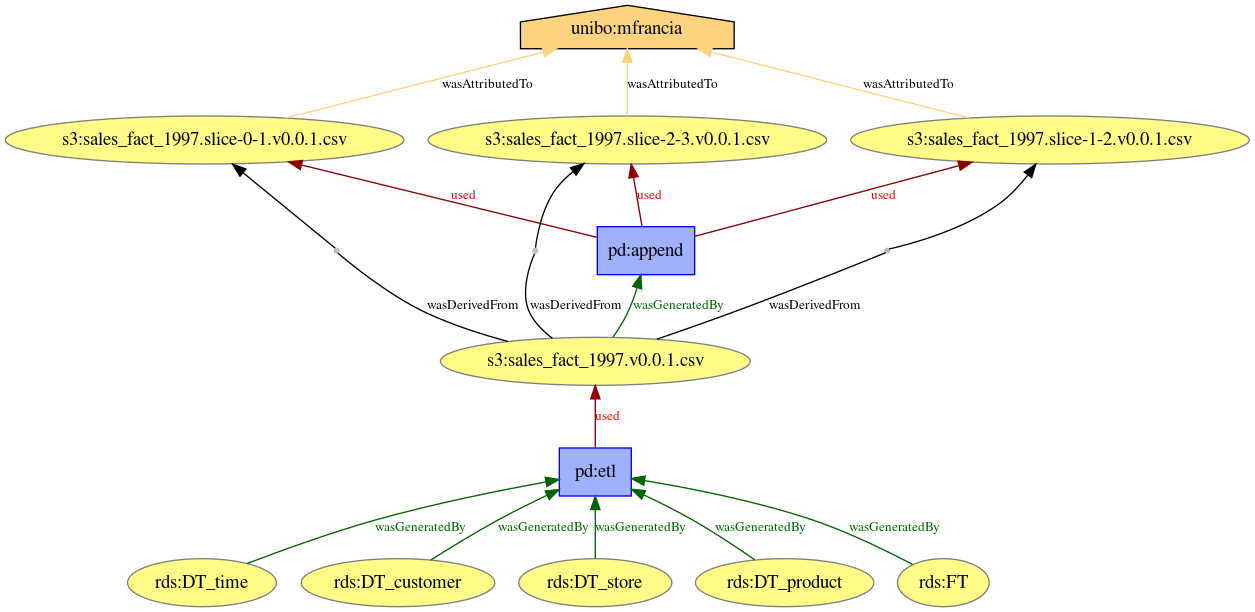

In [27]:
plot()